# Lab №2

## Выполнение

### 0. Импортируем необходимые библиотеки 

In [1]:
from math import pi
import numpy as np
import roboticstoolbox as rtb
import matplotlib.pyplot as plt
import spatialmath.base as sb

### 1. Импортируем модель Puma560

In [2]:
robot = rtb.models.DH.Puma560()
print(robot)

DHRobot: Puma 560 (by Unimation), 6 joints (RRRRRR), dynamics, geometry, standard DH parameters
┌─────┬────────┬────────┬────────┬─────────┬────────┐
│ θⱼ  │   dⱼ   │   aⱼ   │   ⍺ⱼ   │   q⁻    │   q⁺   │
├─────┼────────┼────────┼────────┼─────────┼────────┤
│  q1 │ 0.6718 │      0 │  90.0° │ -160.0° │ 160.0° │
│  q2 │      0 │ 0.4318 │   0.0° │ -110.0° │ 110.0° │
│  q3 │   0.15 │ 0.0203 │ -90.0° │ -135.0° │ 135.0° │
│  q4 │ 0.4318 │      0 │  90.0° │ -266.0° │ 266.0° │
│  q5 │      0 │      0 │ -90.0° │ -100.0° │ 100.0° │
│  q6 │      0 │      0 │   0.0° │ -266.0° │ 266.0° │
└─────┴────────┴────────┴────────┴─────────┴────────┘

┌──┬──┐
└──┴──┘

┌──────┬─────┬──────┬───────┬─────┬──────┬─────┐
│ name │ q0  │ q1   │ q2    │ q3  │ q4   │ q5  │
├──────┼─────┼──────┼───────┼─────┼──────┼─────┤
│   qr │  0° │  90° │ -90°  │  0° │  0°  │  0° │
│   qz │  0° │  0°  │  0°   │  0° │  0°  │  0° │
│   qn │  0° │  45° │  180° │  0° │  45° │  0° │
│   qs │  0° │  0°  │ -90°  │  0° │  0°  │  0° │
└──

### 2. Зададим начальное положение робота и построим его

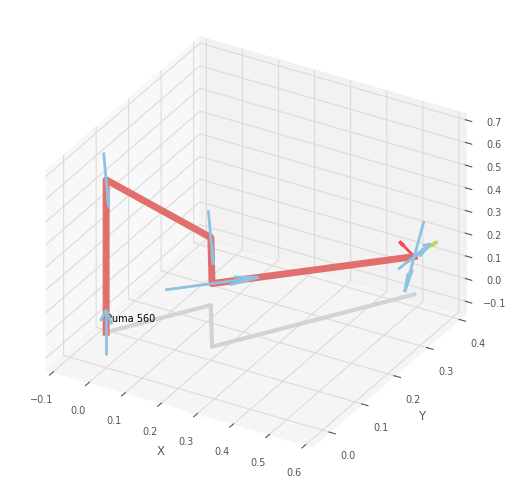

<Figure size 640x480 with 0 Axes>

In [3]:
q_start = [pi/4, -pi/3, -pi/4, pi/3, -pi/3, pi/4]
robot.plot(q_start)
plt.show()

### 3. Решим прямую задачу кинематики

In [4]:
T_start = robot.fkine(q_start)
print(T_start)

  -0.805     0.5292   -0.2681    0.55      
   0.128     0.5962    0.7926    0.3378    
   0.5792    0.6038   -0.5477    0.1665    
   0         0         0         1         



### 6. Построим рабочую зону манипулятора

Инициализируем переменные

In [5]:
n = 20  # Количество точек по каждой оси
i = 0  # Просто счетчик
move = [np.linspace(robot.links[i].qlim[0], robot.links[i].qlim[1], n) for i in range(3)]  # Записываем пределы перемещения для первых трех звеньев
pose = np.zeros([3,n**3])  # Создаем пустой массив для записи данных

Рассчитываем рабочую зону

In [6]:
# Проходимся перебором по каждой точке
for q1 in move[0]:
    for q2 in move[1]:
        for q3 in move[2]:
            Tt = robot.fkine([q1,q2,q3,0,0,0])  # Решаем ПЗК, меняя только первые 3 обобщенных координаты
            for j in range(3):
                pose[j][i] = Tt.t[j]  # Сохраняем точку
            i += 1

Строим рабочую зону

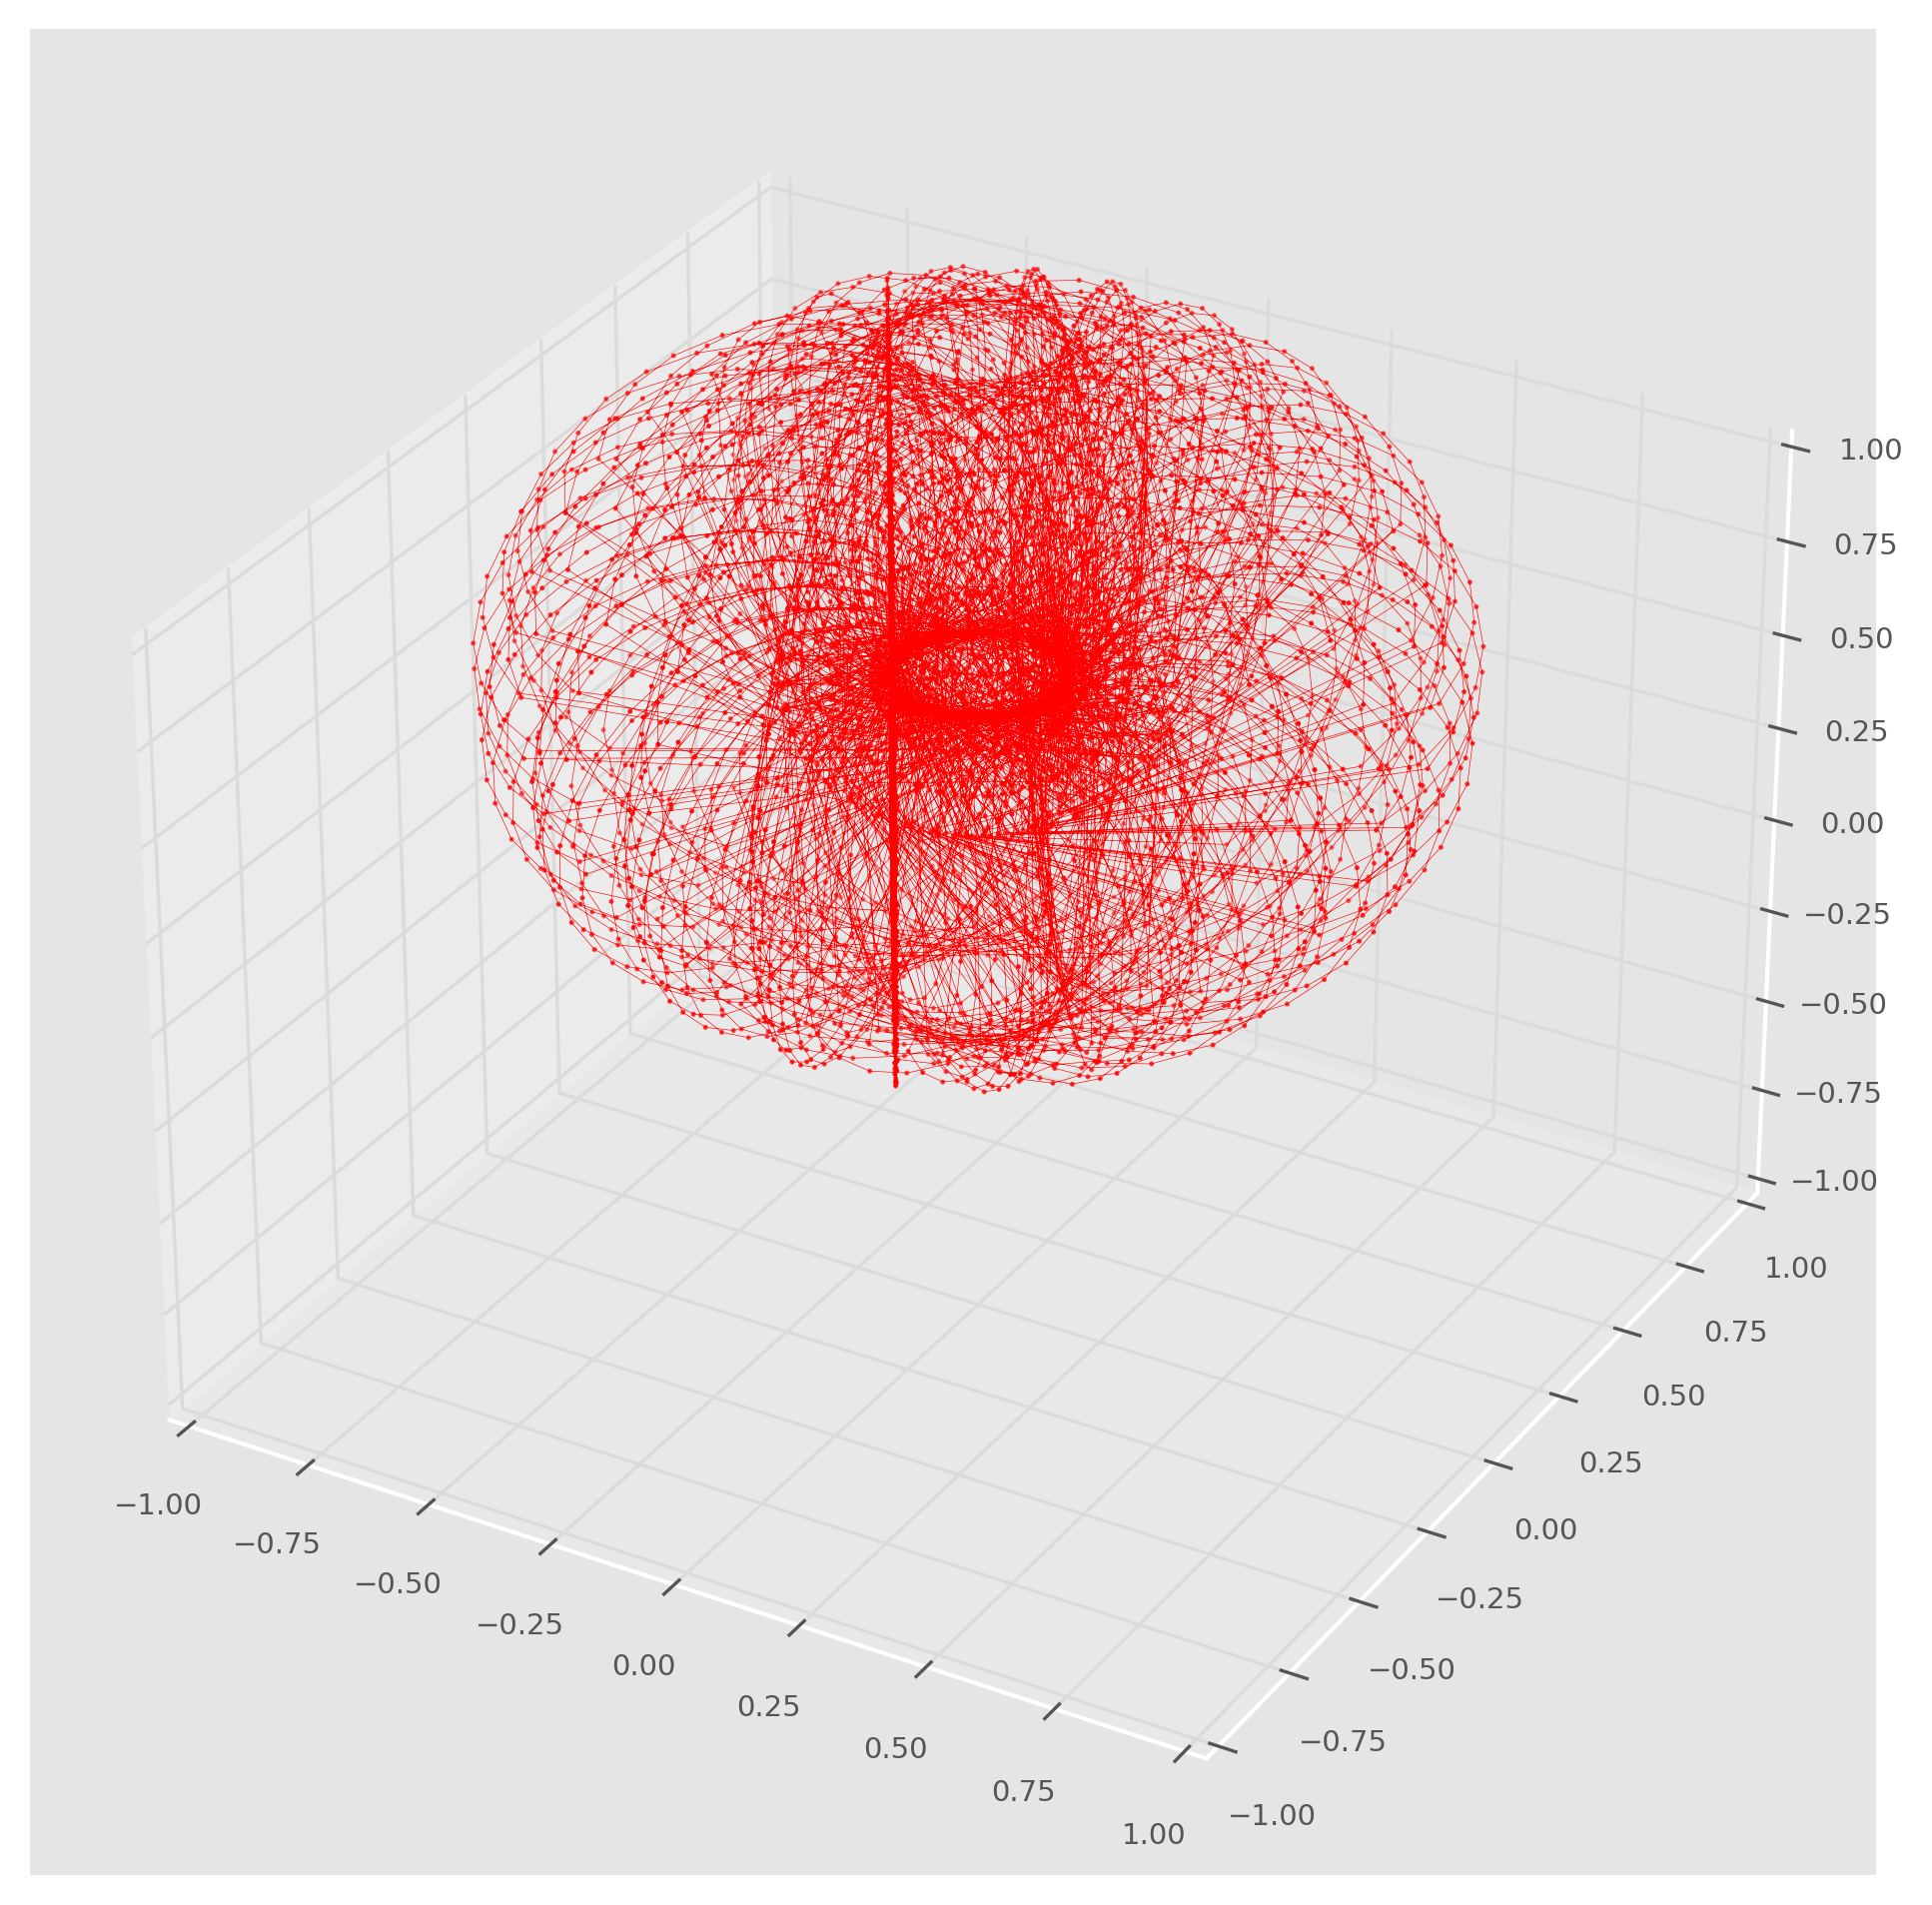

In [7]:
plt.figure(figsize=(8,8), dpi=300)
ax = plt.axes(projection="3d")
ax.plot3D(pose[0], pose[1], pose[2], color='red', linewidth=0.15)
ax.scatter3D(pose[0], pose[1], pose[2], s=0.5, color='red')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
plt.show()

### 7. Выберем конечную точку и проверим её (решим обратную задачу кинематики)

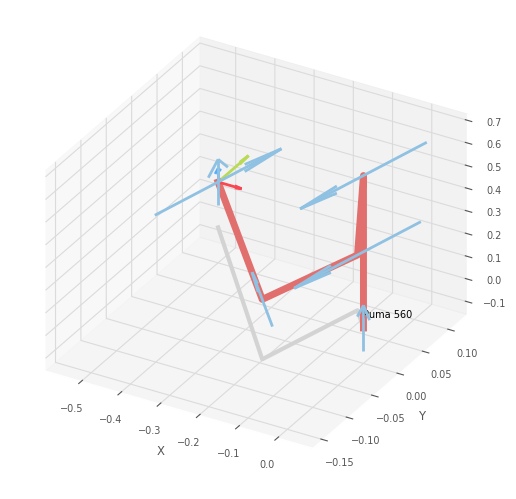

<Figure size 640x480 with 0 Axes>

In [8]:
point = [-0.5,0.1,0.2]
T_end = sb.transl(point)
q_end = robot.ikine_GN(T_end).q  # Есть другие методы, помимо ikine_GN
robot.plot(q_end)
plt.show()

### 8. Спланируем траекторию

Спланируем траекторию методом 'jtraj' для $N$ = 100 точек

In [9]:
N = 100
t_start = 0
t_stop = 5
t_shag = t_stop/N
time = np.arange(t_start, t_stop, t_shag)

tr_jtraj = rtb.jtraj(q_start, q_end, time)

Спланируем ту же траекторию методом 'mtraj' с функцией 'trapezoidal'

In [10]:
tr_trap = rtb.mtraj(rtb.trapezoidal, q_start, q_end, time)

Спланируем ту же траекторию методом 'mtraj' с функцией 'quintic'

In [11]:
tr_quin = rtb.mtraj(rtb.quintic, q_start, q_end, time)

### 9. Построим графики

Построим графики положений для каждого звена

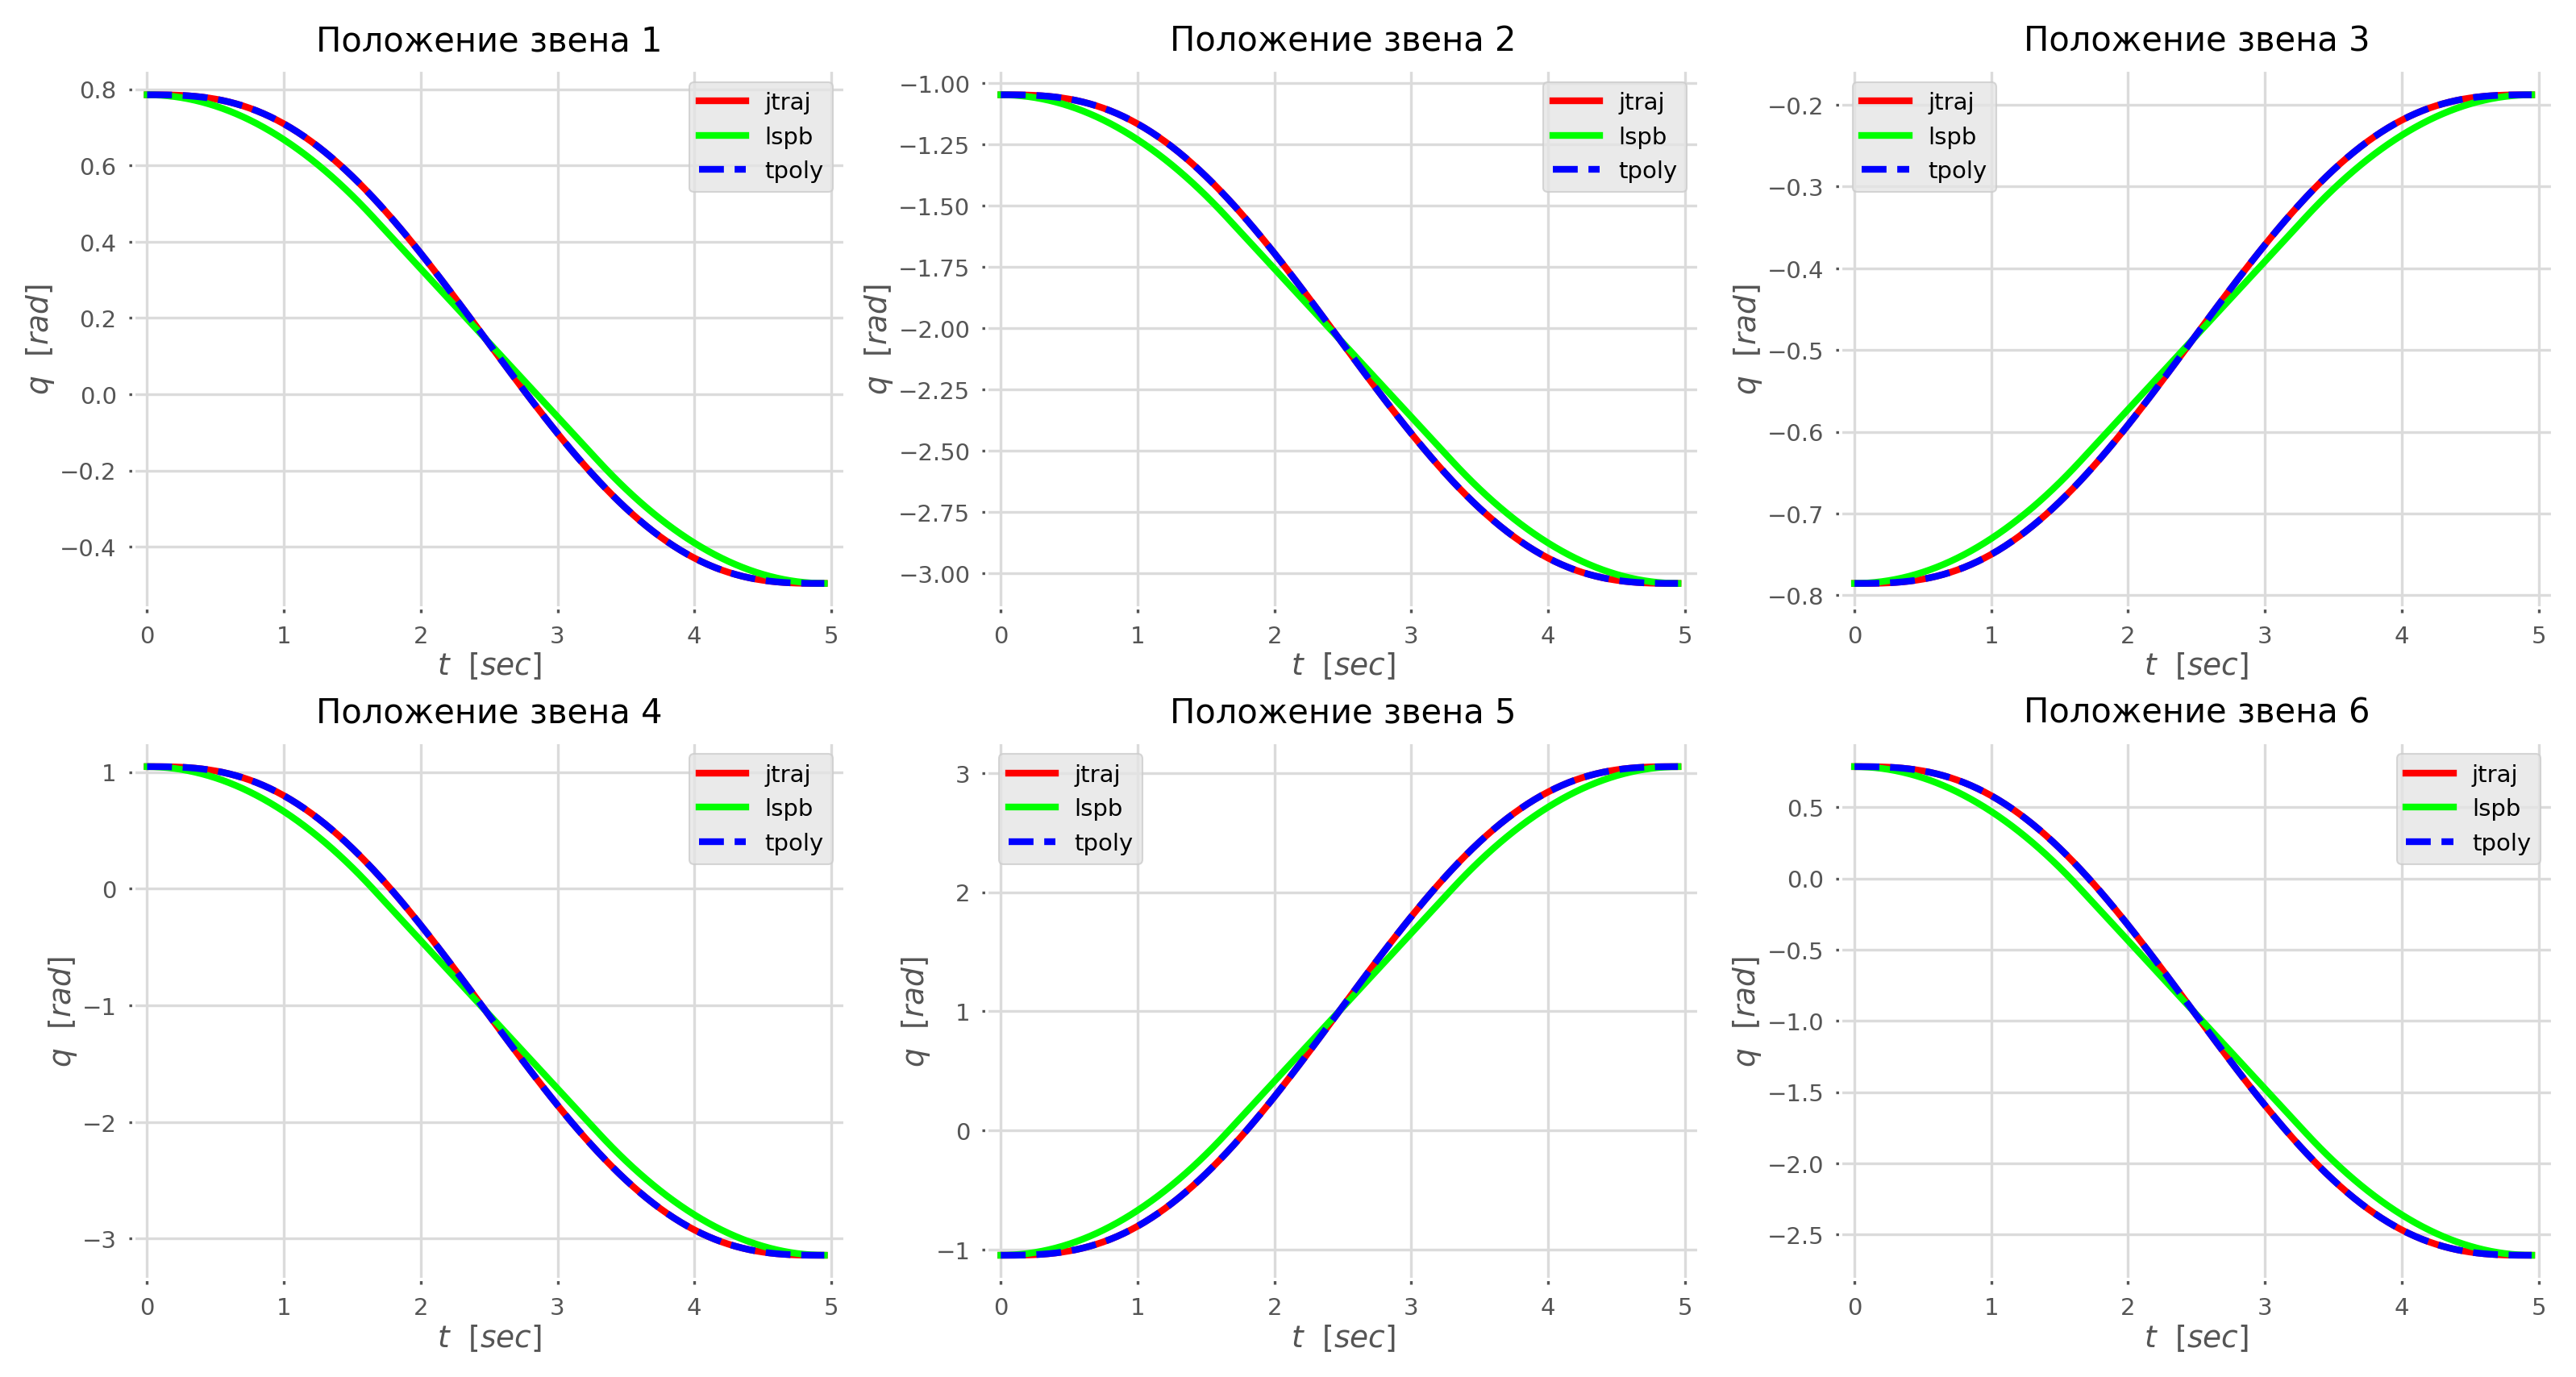

In [20]:
plt.figure(figsize=(10,5), dpi=300)  # Задаем размеры холста и плотность точек (четкость графика)
for g in range(1,7):
    plt.subplot(2,3,g)
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.25)  # Задаем интервалы между графиками, чтоб не перекрывали друг друга
    traektoriya_jtraj = [tr_jtraj.q[i][g-1] for i in range(len(tr_jtraj.q))]  # Извлекаем нужные данные
    traektoriya_trap = [tr_trap.q[i][g-1] for i in range(len(tr_trap.q))]  # Извлекаем нужные данные
    traektoriya_quin = [tr_quin.q[i][g-1] for i in range(len(tr_quin.q))]  # Извлекаем нужные данные
    plt.plot(time, traektoriya_jtraj, linestyle='-', linewidth=2, color=(1,0,0), label=r"jtraj")  # Рисуем линию
    plt.plot(time, traektoriya_trap, linestyle='-', linewidth=2, color=(0,1,0), label=r"lspb")  # Рисуем линию
    plt.plot(time, traektoriya_quin, linestyle='--', linewidth=2, color=(0,0,1), label=r"tpoly")  # Рисуем линию
    plt.title(r"Положение звена {}".format(g), fontsize=10)  # Название графика
    plt.ylabel(r"$q$  [$rad$]", fontsize=9)  # Подпись оси Y
    plt.xlabel(r"$t$  [$sec$]", fontsize=9)  # Подпись оси X
    plt.grid(True)  # Добавить сетку
    plt.legend()  # Отобразить легенду (покажет то, что написано в 'label')
    ax = plt.gca()  # gca = get current axis - чтобы редактировать конкретную фигуру
    ax.set_facecolor((1,1,1))  # Цвет фона на графике
    ax.set_xlim([t_start-0.1,t_stop+0.1])  # Пределы по оси X
plt.show()

Построим графики скоростей для каждого звена

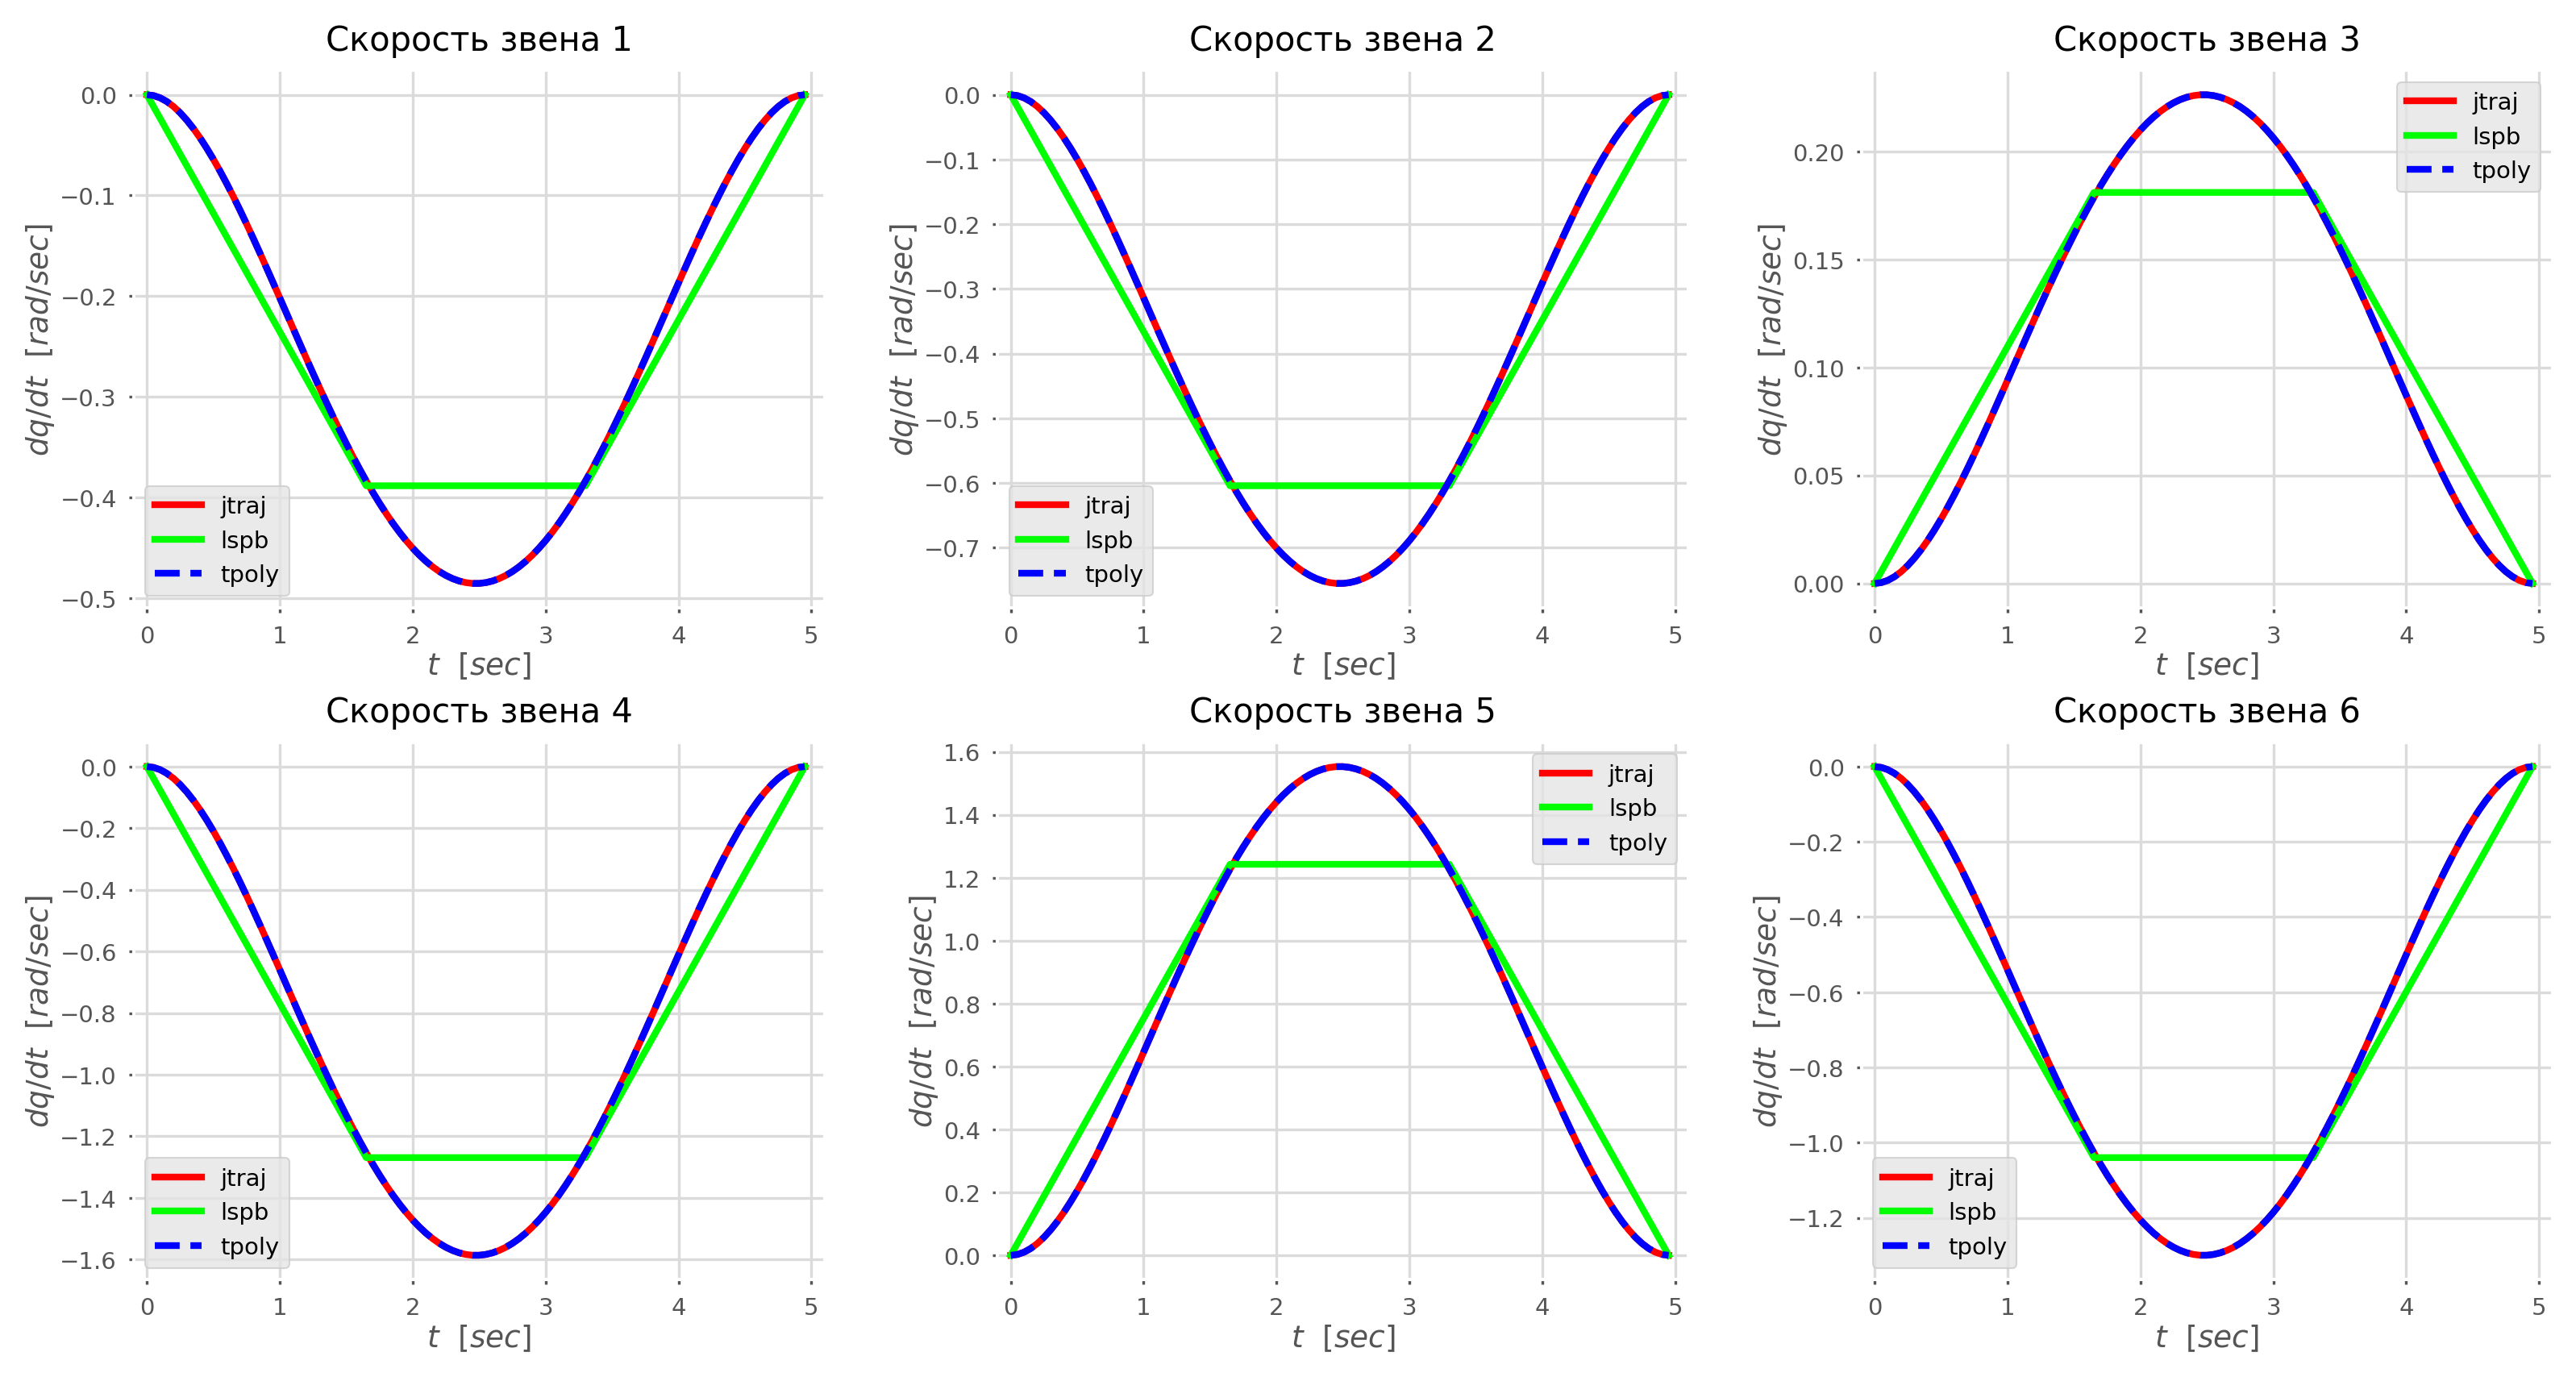

In [21]:
plt.figure(figsize=(10,5), dpi=300)  # Задаем размеры холста и плотность точек (четкость графика)
for g in range(1,7):
    plt.subplot(2,3,g)
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.25, hspace=0.25)  # Задаем интервалы между графиками, чтоб не перекрывали друг друга
    traektoriya_jtraj = [tr_jtraj.qd[i][g-1] for i in range(len(tr_jtraj.qd))]  # Извлекаем нужные данные
    traektoriya_trap = [tr_trap.qd[i][g-1] for i in range(len(tr_trap.qd))]  # Извлекаем нужные данные
    traektoriya_quin = [tr_quin.qd[i][g-1] for i in range(len(tr_quin.qd))]  # Извлекаем нужные данные
    plt.plot(time, traektoriya_jtraj, linestyle='-', linewidth=2, color=(1,0,0), label=r"jtraj")  # Рисуем линию
    plt.plot(time, traektoriya_trap, linestyle='-', linewidth=2, color=(0,1,0), label=r"lspb")  # Рисуем линию
    plt.plot(time, traektoriya_quin, linestyle='--', linewidth=2, color=(0,0,1), label=r"tpoly")  # Рисуем линию
    plt.title(r"Скорость звена {}".format(g), fontsize=10)  # Название графика
    plt.ylabel(r"$dq/dt$  [$rad/sec$]", fontsize=9)  # Подпись оси Y
    plt.xlabel(r"$t$  [$sec$]", fontsize=9)  # Подпись оси X
    plt.grid(True)  # Добавить сетку
    plt.legend()  # Отобразить легенду (покажет то, что написано в 'label')
    ax = plt.gca()  # gca = get current axis - чтобы редактировать конкретную фигуру
    ax.set_facecolor((1,1,1))  # Цвет фона на графике
    ax.set_xlim([t_start-0.1,t_stop+0.1])  # Пределы по оси X
plt.show()

Построим графики ускорений для каждого звена

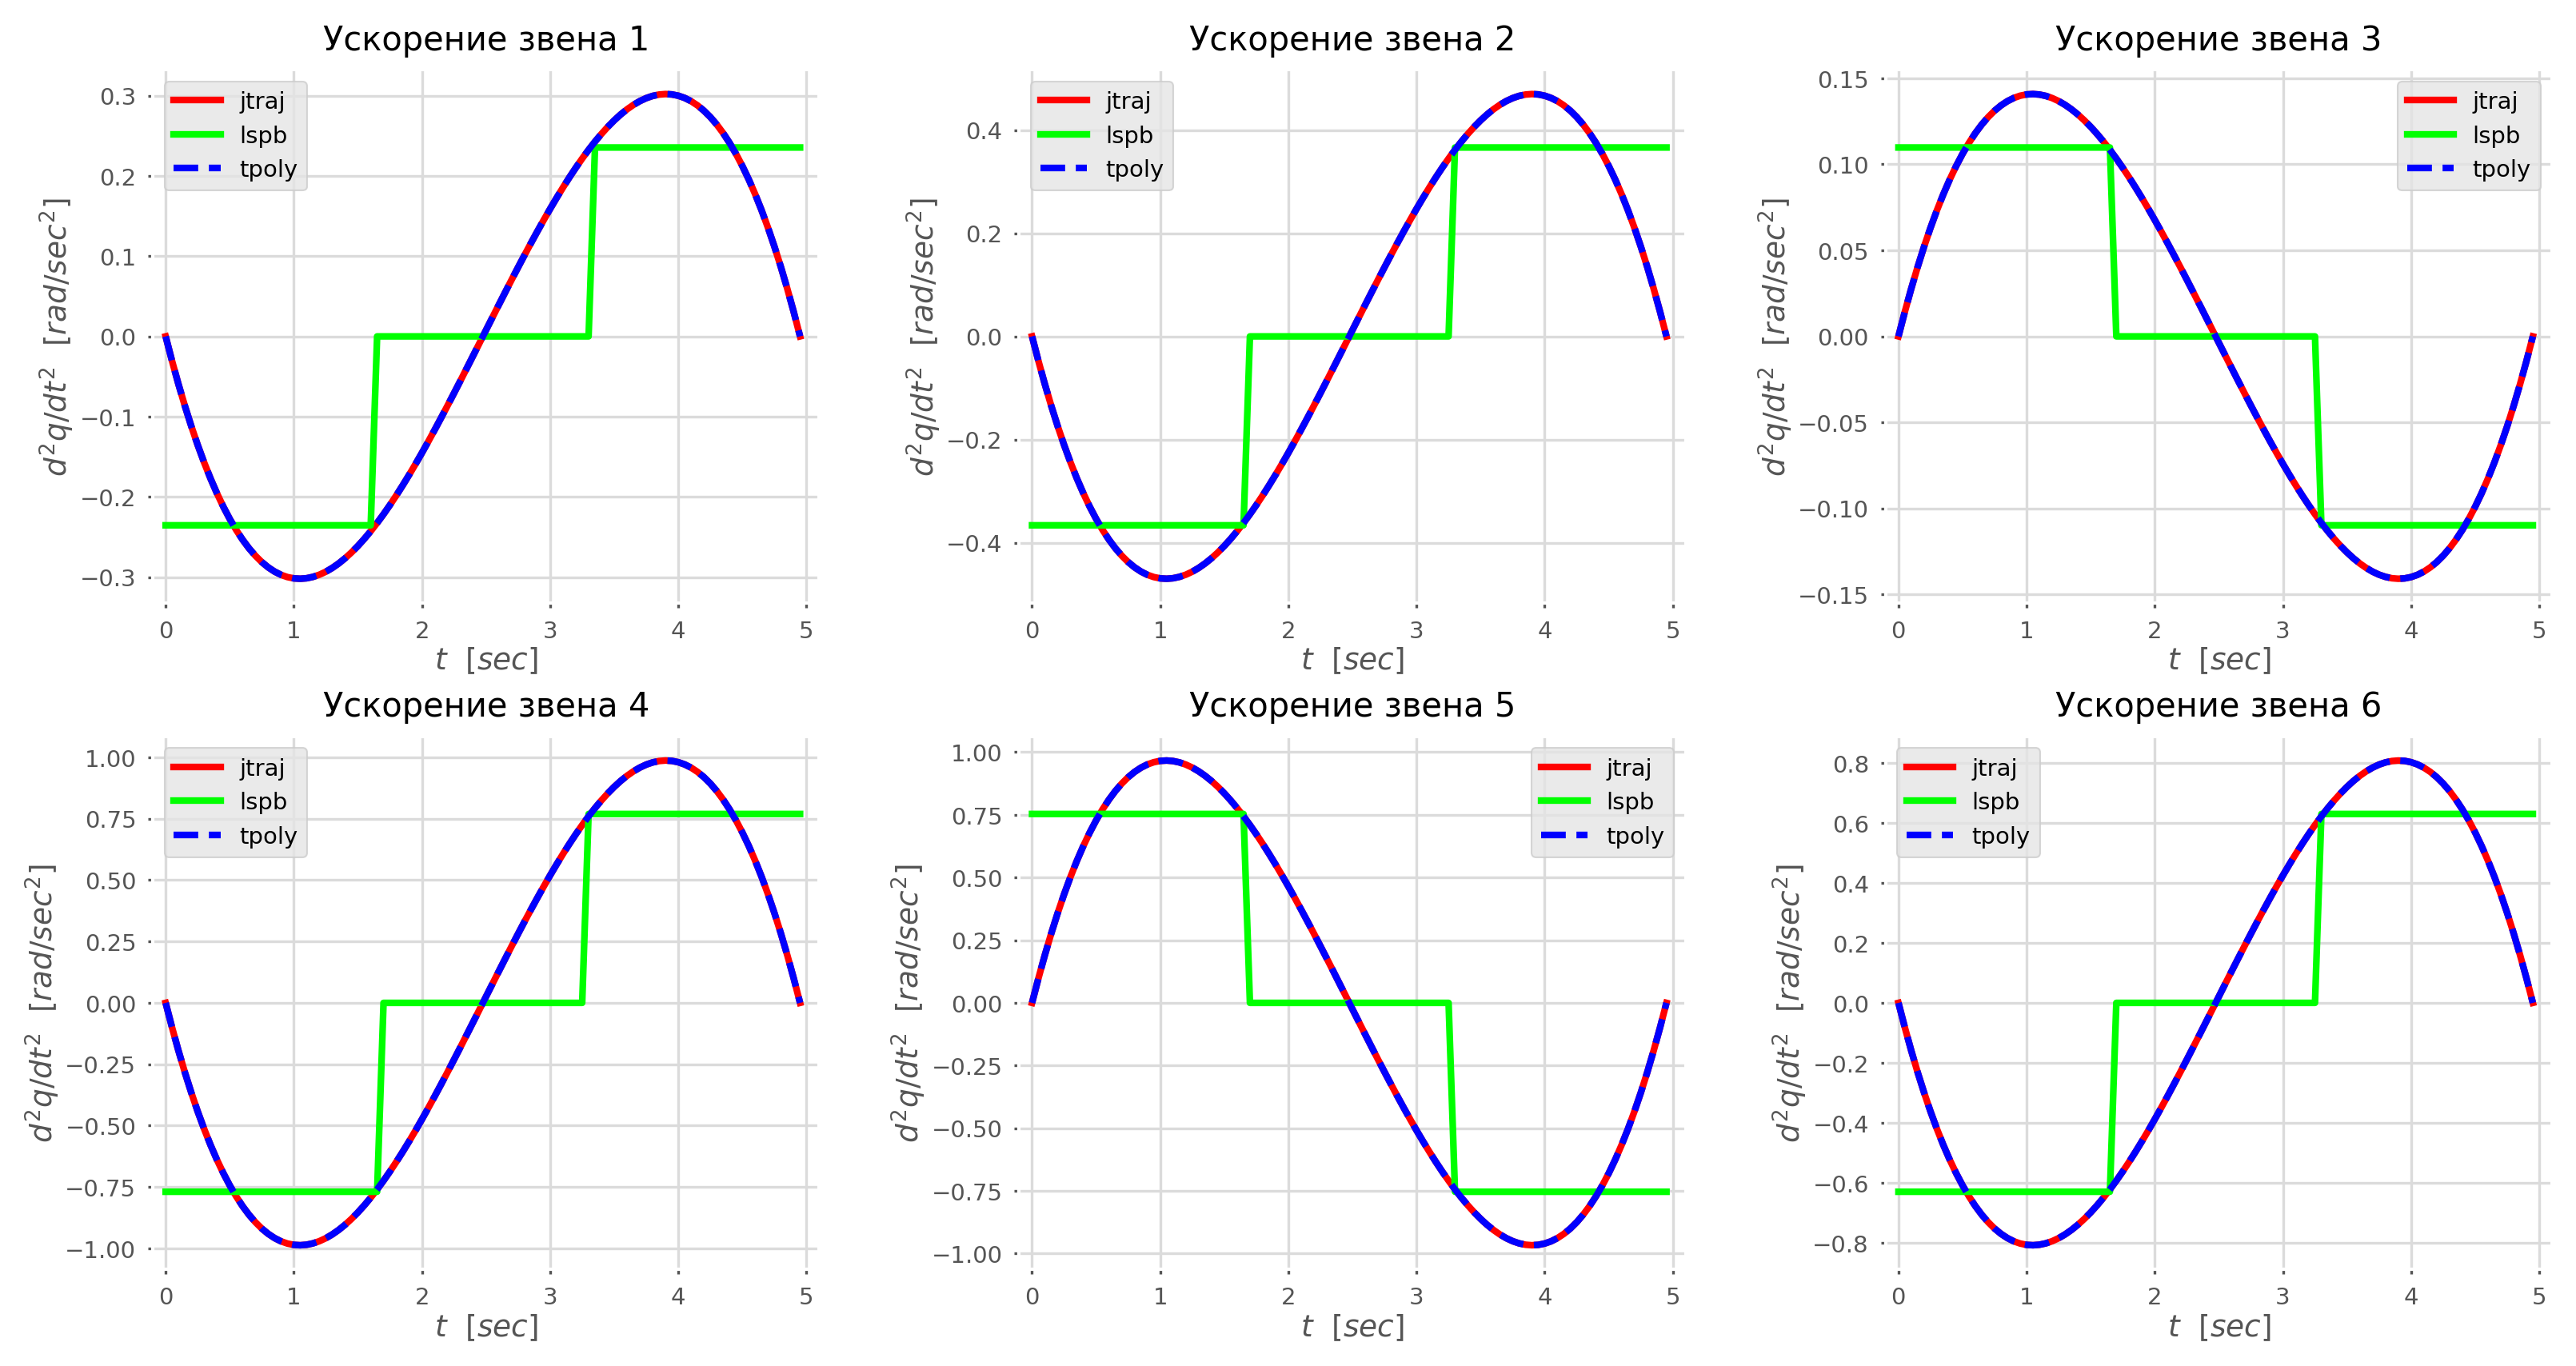

In [22]:
fig = plt.figure(figsize=(10,5), dpi=300)  # Задаем размеры холста и плотность точек (четкость графика)
for g in range(1,7):
    plt.subplot(2,3,g)
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.25)  # Задаем интервалы между графиками, чтоб не перекрывали друг друга
    traektoriya_jtraj = [tr_jtraj.qdd[i][g-1] for i in range(len(tr_jtraj.qdd))]  # Извлекаем нужные данные
    traektoriya_trap = [tr_trap.qdd[i][g-1] for i in range(len(tr_trap.qdd))]  # Извлекаем нужные данные
    traektoriya_quin = [tr_quin.qdd[i][g-1] for i in range(len(tr_quin.qdd))]  # Извлекаем нужные данные
    plt.plot(time, traektoriya_jtraj, linestyle='-', linewidth=2, color=(1,0,0), label=r"jtraj")  # Рисуем линию
    plt.plot(time, traektoriya_trap, linestyle='-', linewidth=2, color=(0,1,0), label=r"lspb")  # Рисуем линию
    plt.plot(time, traektoriya_quin, linestyle='--', linewidth=2, color=(0,0,1), label=r"tpoly")  # Рисуем линию
    plt.title(r"Ускорение звена {}".format(g), fontsize=10)  # Название графика
    plt.ylabel(r"${d^2}q/d{t^2}$  [$rad/{sec}^2$]", fontsize=9)  # Подпись оси Y
    plt.xlabel(r"$t$  [$sec$]", fontsize=9)  # Подпись оси X
    plt.grid(True)  # Добавить сетку
    plt.legend()  # Отобразить легенду (покажет то, что написано в 'label')
    ax = plt.gca()  # gca = get current axis - чтобы редактировать конкретную фигуру
    ax.set_facecolor((1,1,1))  # Цвет фона на графике
    ax.set_xlim([t_start-0.1,t_stop+0.1])  # Пределы по оси X
plt.show()